In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, date
from statistics import mean 
import copy
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
from sklearn.preprocessing import StandardScaler
sns.set(rc={'figure.figsize':(11,8)})
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 1000)
plt.rcParams["axes.grid"] = False
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os


paths = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        paths.append(os.path.join(dirname,filename))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


In [2]:
# General path variables which we'll use throughout the code
lotteryPath = paths[0]

# Load the Dataset

First, Let's load our main lottery dataframe and visualize the content
*  Draw Number: Self explanatory
*  Jackpot: Jackpot available for the winner
*  Date: Date of Draw
*  Ball 1, 2, 3, 4, 5, 6 & Extra Ball: Drawn balls with their respective order

In [3]:
# Any results you write to the current directory are saved as output.
lottery = pd.read_csv(lotteryPath, encoding='latin-1')
lottery

,Draw Number,Jackpot,Date,Ball 1,Ball 2,Ball 3,Ball 4,Ball 5,Ball 6,Extra Ball
0,1,$0,2002-09-12,7,25,11,8,20,32,30
1,2,$0,2002-09-19,5,19,13,42,21,28,35
2,3,$0,2002-09-26,4,10,18,35,36,38,21
3,4,"$1,086,669",2002-10-03,8,16,17,23,29,32,7
4,5,$0,2002-10-10,4,7,10,16,27,41,12
...,...,...,...,...,...,...,...,...,...,...
1796,1797,"$1,700,509",2020-02-27,4,21,25,29,32,38,9
1797,1798,"$1,794,323",2020-03-02,12,21,25,27,31,37,35
1798,1799,"$1,890,869",2020-03-05,2,5,8,16,22,29,33
1799,1800,"$1,985,964",2020-03-09,2,9,14,36,37,41,42


# Visualize Overall Distribution

To better understand what's happening, let's start with the basics.
We'll try to answer the following question: 
*  What distribution does the lottery follow?

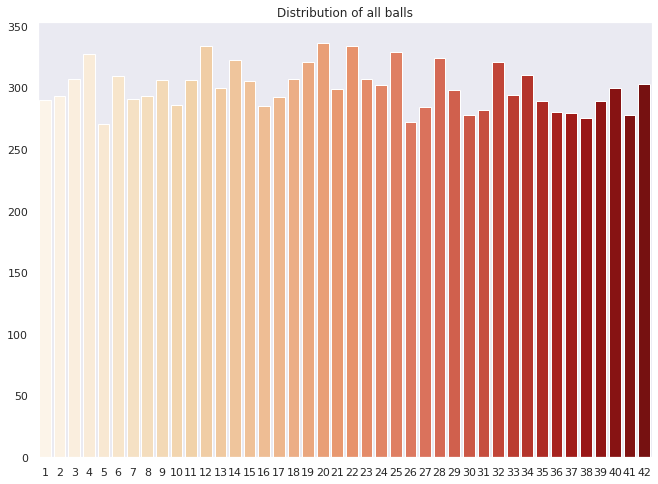

In [4]:
all_balls = {}
for i in range(1,7):
    ball_ser = lottery['Ball ' +str(i)].value_counts()
    for key in ball_ser.keys():
        all_balls[key] = all_balls.get(key,0) + ball_ser[key]
        
ball_ser = lottery['Extra Ball'].value_counts()
for key in ball_ser.keys():
    all_balls[key] = all_balls.get(key,0) + ball_ser[key]

all_balls = pd.Series(all_balls) 

plt.title('Distribution of all balls')
plt.xticks(rotation=0)
sns.barplot(x=all_balls.keys(), y=all_balls.values, palette="OrRd")

So the result we got describes a uniform distribution.
Technically, that's what every lottery should look like, since it must assure equal probability of having any of the elements.

# Distribution of each ball

So now that we got the overall distribution of all of the balls, let's try to examine the underlying distribution of each ball.
Maybe, we'll have something fishy down there

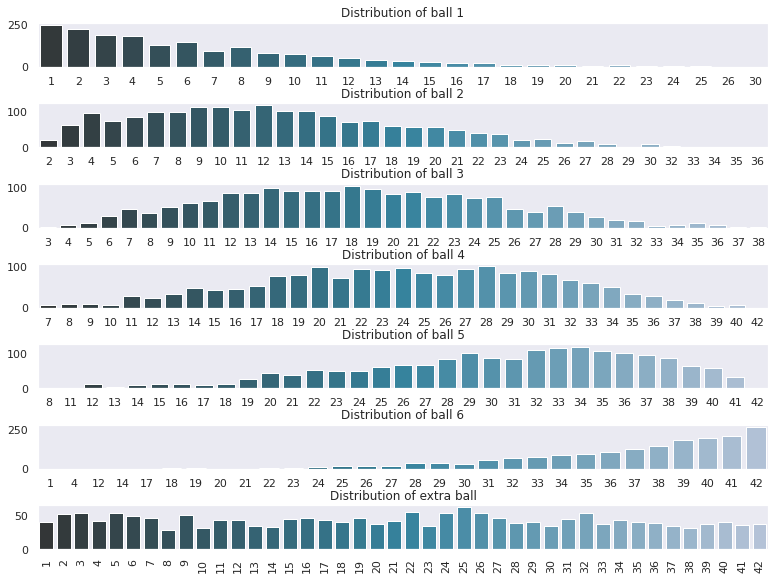

In [5]:
# Visualize the distributions of each ball
f, axes = plt.subplots(7, 1)
f.tight_layout() 
for i in range(1,7):
    ball_dist = lottery['Ball ' +str(i)].value_counts().sort_index()
    axes[i-1].set_title('Distribution of ball '+str(i))
    plt.xticks(rotation=90)
    sns.barplot(x=ball_dist.keys(), y=ball_dist.values, ax=axes[i-1], palette="PuBuGn_d")

ball_dist = lottery['Extra Ball'].value_counts().sort_index()
axes[6].set_title('Distribution of extra ball')
plt.xticks(rotation=90)
sns.barplot(x=ball_dist.keys(), y=ball_dist.values, ax=axes[6], palette="PuBuGn_d")

# Wait, what? Shouldn't that be uniform?

Short answer, yes it should!  
However, more insights about the data showed that LLDJ (La libanaise des jeux) ordered the numbers before posting them on their website.  
That being said, the distribution of the balls is irrelevant in this case, we only look back to the main distribution of the whole system.  
In simple terms, the order of the balls does not affect the result.  
The visualization here only showcases the distribution for the ordered data, which is not what's happening really.

# More insights in the correlation matrix

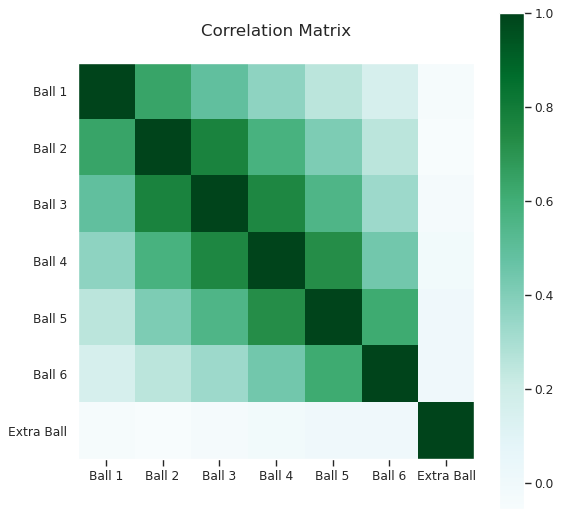

In [6]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    #filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    del df['Draw Number']
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr('pearson')
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1,cmap = "BuGn")
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=0)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
   
    plt.title(f'Correlation Matrix', fontsize=15)
    plt.show()
plotCorrelationMatrix(lottery, 8)

# Analysis

## WE ARE TAKING IN CONSIDERATION THAT THE BALLS ARE ORDERED

A little elaboration on the number distributions would explain what really is happening in the correlation matrix.  
So, let's state our main points that we'll rely on to build on in further analysis:
* Each Individual ball has a normal distribution holding possible numbers that it can take.
* The distributions of the 6 random balls (not the extra ball) have the same standard deviation and have means -more or less- equally distributed along numbers 1 -> 42  

Since the distributions are shifted following a consecutive order, we are able to correlate Balls sequences with each other.  
The first obvious observation is that every ball correlates maximum with itself, since we're correlating the same distribution with itself.  
To elaborate on the latter, the next consecutive ball (Ex. Ball 4 then Ball 5) would generate also a substantial correlation. *But why is that?*   
Well, since consecutive normal distributions hold regions of intersections (of possible numbers to take) then correlating the same numbers with each other will increase the relationship. You may look back to the ball distribution figure above to get a better feel of this.  
So, in simple terms, yes consecutive balls have correlations between them due to the intersection of their distributions. (That explains the perfect correlation of the ball with itself).  
Going on, the further the balls are, the more distant their distributions, the less the intersection, the less their correlation.

### That leads us to the Extra Ball

We already know that Ball 1 -> Ball 6 have normal distributions and the extra ball follows a uniform distribution.  
In the same line of thought, the extra ball has intersections with all of the distributions. But due to its uniformity, the occurence of each ball is deminished to provide equal probability **and** that means that typically the correlation to each of the distributions should be the same, while also proving a close to zero correlation.

# Now what?

Maybe more details will give insight about a possible flaw.  
> "The devil lies in the details"

In [7]:
def getDate(strDate):
    return datetime.strptime(strDate, '%Y-%m-%d').date()

# Occurences per Month

Let's start looking into occurences per month.  
That means we need to visualize the occurence of each ball on a monthly basis.

## Step 1 

### Define the underlying data structure

In [8]:
# This list will hold all of the monthly draws
allMonthsData = []

# The data that will be held will simply have the date of the draw along with the {"ball drawn": occurence}
class MonthData:
    def __init__(self,date,ballsDict):
        self.date = date
        self.ballsDict = ballsDict

## Step 2

### Helper functions

* **generateStatsForDraws(draws, drawDate)**  
This function takes care of counting the drawn balls and storing them appropriately in the allMonthsData list.  

* **plotBallsInMonths(index)**  
Plot the occurences of balls for the index of the month given.

#### N.B: Months are already sorted from the main dataframe, that means that index 0 is the first draw.

In [9]:
# What we know about these draws is that they'll be part of the same month
def generateStatsForDraws(draws, drawDate):
    if(draws.empty == False):
        currentBalls = {}
        del draws['Date']
        del draws['Draw Number']
        del draws['Jackpot']
        balls_list = draws.values.T.tolist()
        balls_flat_list = [item for sublist in balls_list for item in sublist]
        for i in range(1,43):
            currentBalls[i] = balls_flat_list.count(i)
        data = MonthData(drawDate, currentBalls)
        allMonthsData.append(data)


        
def plotBallsInMonths(index):
    all_balls = pd.Series(allMonthsData[index].ballsDict) 
    plt.title('Balls in ' + str(allMonthsData[index].date.month) + "-" + str(allMonthsData[index].date.year))
    plt.xticks(rotation=0)
    sns.barplot(x=all_balls.keys(), y=all_balls.values, palette="GnBu_d")

## Step 3

### Organize draws by dates 

* **ball_month**  
The dataframe holds all draws for a given month (used within the for loop).  

#### N.B: Months are already sorted from the main dataframe, that means that index 0 is the first draw.

In [10]:
ball_month = pd.DataFrame()

initDate = getDate(lottery['Date'][0])
currentMonth = initDate.month
currentYear = initDate.year

def getOccurencesPerMonth():
    global ball_month
    global currentMonth
    global currentYear
    for index, draw in lottery.iterrows():
        drawDate = getDate(draw['Date'])
        if(drawDate.month == currentMonth  and drawDate.year == currentYear): 
            ball_month = ball_month.append(draw)
        else:
            generateStatsForDraws(ball_month,drawDate)
            ball_month = pd.DataFrame()
            currentMonth = (currentMonth % 12) + 1 
            if(currentYear != drawDate.year):
                currentYear = drawDate.year


## Step 4

### Call the main method

In [11]:
getOccurencesPerMonth()

## Step 5

### Visualize balls for each month

I know, I know, I could have optimized my code better.  
Nevertheless, for the time being, index 0 is the first month, 1 is the second, etc.. 

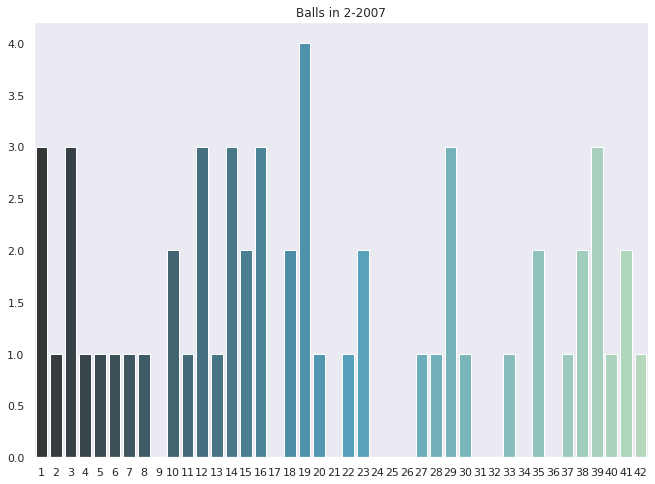

In [12]:
plotBallsInMonths(50)

# Results

Well, nothing additional really.  
Just more visualizations of the data.  
The results keep showing that the distribution is more or less uniform monthly (what did you expect? the main distribution already shows that)


# Occurences per Year

This one is very similar to the latter, I wont explain the code.  
Mainly duplicated with slight changes.  
Only change here is the visualization, you'll get a better feel of what the data means

In [13]:
# I want to know on how many interval is each ball appearing
# For ex: #23 appeared X times this year

ball_dataset = pd.DataFrame(columns = ['Year', 'Ball Number', 'Occurences'])
ball_dataset["Year"] = pd.to_numeric(ball_dataset["Year"])
ball_dataset["Ball Number"] = pd.to_numeric(ball_dataset["Ball Number"])
ball_dataset["Occurences"] = pd.to_numeric(ball_dataset["Occurences"])



# What we know about these draws is that they'll be part of the same month
# So we can have a data frame of that month where we count the numbers
def generateYearStatsForDraws(draws, drawDate):
    global ball_dataset
    if(draws.empty == False):
        currentBalls = {}
        #print(draws)
        del draws['Date']
        #print(draws)
        balls_list = draws.values.T.tolist()
        balls_flat_list = [item for sublist in balls_list for item in sublist]
        #print(balls_flat_list)
        for i in range(1,43):
            currentBalls['Year'] = int(drawDate.year)
            currentBalls['Ball Number'] = int(i)
            currentBalls['Occurences'] = int(balls_flat_list.count(i))
            ball_at_year = pd.Series(currentBalls)
            currentBalls = {}
            ball_dataset = ball_dataset.append(ball_at_year, ignore_index = True)
        #print("yalla")
        
        
ball_month = pd.DataFrame()

initDate = getDate(lottery['Date'][0])
currentMonth = initDate.month
currentYear = initDate.year

for index, draw in lottery.iterrows():
    del draw['Draw Number']
    del draw['Jackpot']
    drawDate = getDate(draw['Date'])
    if(drawDate.month == currentMonth  and drawDate.year == currentYear): 
        #print(draw['Date'])
        ball_month = ball_month.append(draw)
    else:
        #break
        #print("New Month")
        currentMonth = (currentMonth % 12) + 1 
        if(currentYear != drawDate.year):
            #print("New Year")
            #print(ball_month)
            generateYearStatsForDraws(ball_month, drawDate)
            ball_month = pd.DataFrame()
            currentYear = drawDate.year


print(ball_dataset)    
    
        

     Year  Ball Number  Occurences
0    2003            1           1
1    2003            2           0
2    2003            3           1
3    2003            4           5
4    2003            5           2
..    ...          ...         ...
751  2020           38          17
752  2020           39          19
753  2020           40          19
754  2020           41          10
755  2020           42          16

[756 rows x 3 columns]


# Heatmap of occurences

X axis represents the year, Y axis is the ball number and the value encapsulated represents the occurance of that number within this year.

## Some observations

1. 2003 was the first actual lottery year, so it typically doesn't hold data for all months.

2. 2006 held a war *(won't go into that)*, so lottery draws deminished

3. Everything else shows up pretty uniform, no real discrepencies in the data

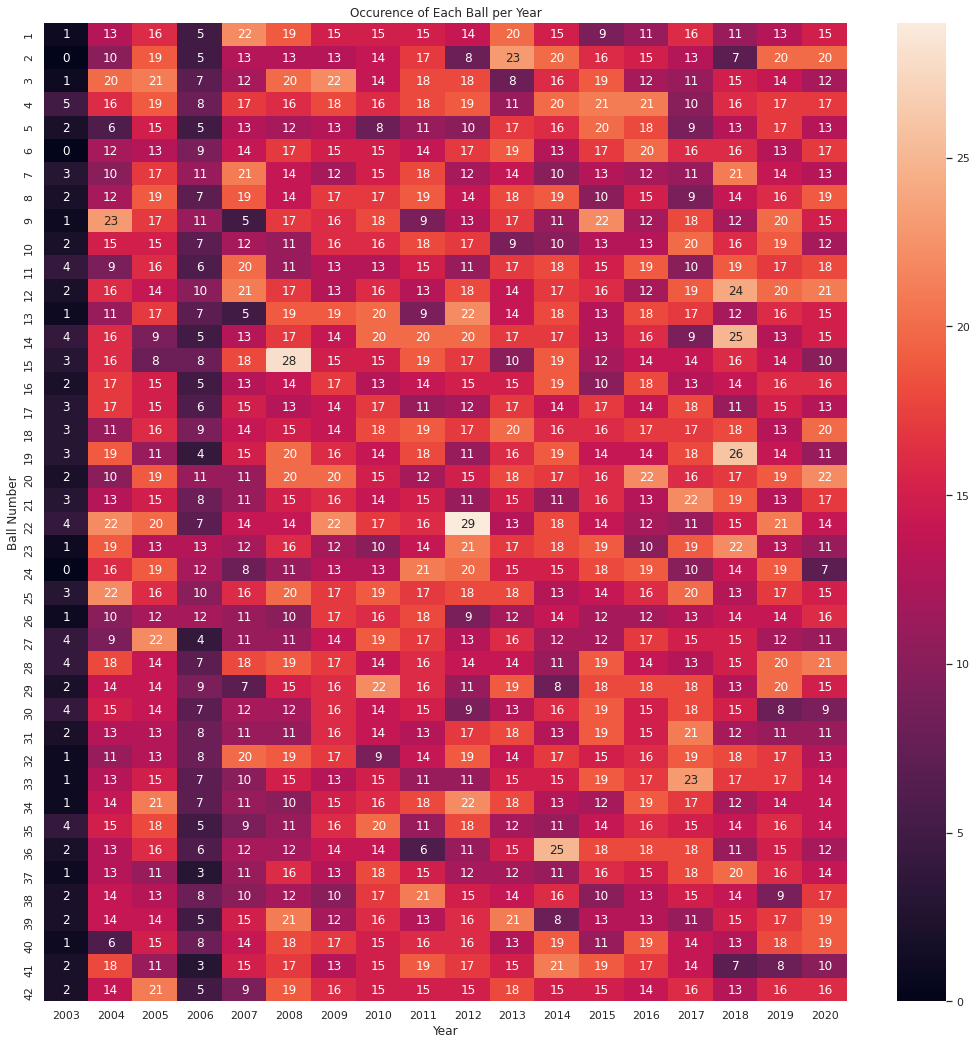

In [14]:
balls = ball_dataset.pivot("Ball Number", "Year", "Occurences")
f, ax = plt.subplots(figsize=(18, 18))
plt.title("Occurence of Each Ball per Year")
sns.heatmap(balls, annot=True, fmt="d", linewidths=0.0, ax=ax)

# Let's make things interesting...

So let's start by examinating some of the combinations which lead to higher probabilities.  
The most famous one is the ~**_even odd_**~ distribution.  
Let's see how it works, I will first develop the code and we'll then explain it.

### For the sake of simplicity, we'll ignore the extra number since we only care about the jackpot 

#### We'll evalute the following cases

* 0 even 6 odd
* 1 even 5 odd
* 2 even 4 odd
* 3 even 3 odd
* 4 even 2 odd
* 5 even 1 odd
* 6 even 0 odd

3 Even, 3 Odd    587
2 Even, 4 Odd    422
5 Even, 1 Odd    149
4 Even, 2 Odd    486
0 Even, 6 Odd     20
1 Even, 5 Odd    122
6 Even, 0 Odd     15
dtype: int64


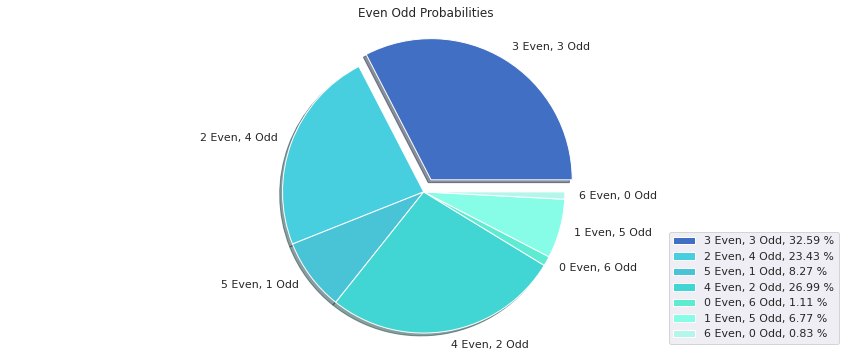

In [15]:
# Get number of even and odd numbers in a given list
def getNumberOfEvenAndOdd(numbers):
    countEven = 0
    countOdd = 0
    for number in numbers:
        if number % 2 == 0:
            countEven += 1
        else:
            countOdd += 1
    return str(countEven) + " Even, " +str(countOdd) +" Odd"

def visualizeEvenOddCombination():
    even_odd = {}
    numbers = []
    for index, draw in lottery.iterrows():
            numbers.append(int(draw['Ball 1']))
            numbers.append(int(draw['Ball 2']))
            numbers.append(int(draw['Ball 3']))
            numbers.append(int(draw['Ball 4']))
            numbers.append(int(draw['Ball 5']))
            numbers.append(int(draw['Ball 6']))
            even_odd[getNumberOfEvenAndOdd(numbers)] = even_odd.get(getNumberOfEvenAndOdd(numbers), 0) + 1 
            numbers = []
    even_odd_ser = pd.Series(even_odd)
    print(even_odd_ser)
    # Pie chart, where the slices will be ordered and plotted counter-clockwise:
    labels = even_odd.keys()
    sizes = list(even_odd.values())
    sizes = [x / float(len(lottery)) * 100 for x in sizes]
    explode = (0.1, 0, 0, 0, 0,0,0)  # only "explode" the 2nd slice (i.e. 'Hogs')
    fig1, ax1 = plt.subplots(figsize=(15, 6))
    colors = ["#416fc4", "#48cfdf", "#48c4d6", "#41d6d3", "#5decd2", "#87fde8","#b4f6eb"]
    ax1.pie(sizes, explode=explode, labels=labels,colors = colors, shadow=True)
    plt.title("Even Odd Probabilities")
    plt.legend( loc = 'lower right', labels=['%s, %1.2f %%' % (l, s) for l, s in zip(labels, sizes)])
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    

visualizeEvenOddCombination()

## Analysis

Briefly, around 33% of jackpots were formed from 3 even and 3 odd numbers.  
You can elaborate on the rest.  
Does that mean if you pick 3 even 3 odds you have higher chances to win?  
**Definitely!**  

# High - Low

We'll evaluate another aspect of combination.  
Since the lotto is formed out of 42 numbers, we'll classify two classes of numbers
1. High numbers >= 22
2. Low numbers < 22

You'll remark that the codebase is very similar to the latter

2 High, 4 Low    448
3 High, 3 Low    595
0 High, 6 Low     14
5 High, 1 Low    154
4 High, 2 Low    402
1 High, 5 Low    171
6 High, 0 Low     17
dtype: int64


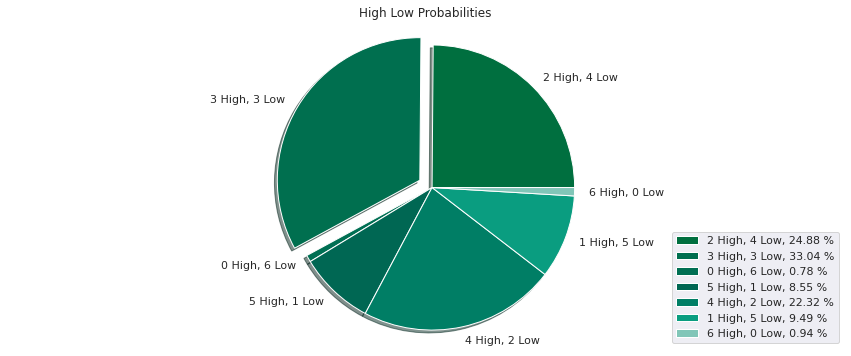

In [16]:
# Get number of even and odd numbers in a given list
def getNumberOfHighAndLow(numbers):
    countHigh = 0
    countLow = 0
    for number in numbers:
        if number >= 22:
            countHigh += 1
        else:
            countLow += 1
    return str(countHigh) + " High, " +str(countLow) +" Low"

def visualizeHighLowCombination():
    high_low = {}
    numbers = []
    for index, draw in lottery.iterrows():
            numbers.append(int(draw['Ball 1']))
            numbers.append(int(draw['Ball 2']))
            numbers.append(int(draw['Ball 3']))
            numbers.append(int(draw['Ball 4']))
            numbers.append(int(draw['Ball 5']))
            numbers.append(int(draw['Ball 6']))
            high_low[getNumberOfHighAndLow(numbers)] = high_low.get(getNumberOfHighAndLow(numbers), 0) + 1 
            numbers = []
    high_low_ser = pd.Series(high_low)
    print(high_low_ser)
    # Pie chart, where the slices will be ordered and plotted counter-clockwise:
    labels = high_low.keys()
    sizes = list(high_low.values())
    sizes = [x / float(len(lottery)) * 100 for x in sizes]
    explode = (0.0, 0.1, 0, 0, 0,0,0)  # only "explode" the 2nd slice (i.e. 'Hogs')
    fig1, ax1 = plt.subplots(figsize=(15, 6))
    colors = ["#006F3F", "#006F4F", "#006F53", "#006753", "#007e65", "#0a9d80","#81c6b8"]
    ax1.pie(sizes, explode=explode, labels=labels,colors = colors, shadow=True)
    plt.title("High Low Probabilities")
    plt.legend( loc = 'lower right', labels=['%s, %1.2f %%' % (l, s) for l, s in zip(labels, sizes)])
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    

visualizeHighLowCombination()

## Analysis

Also, around 33% of jackpots were formed from 3 high and 3 low numbers.  
This is the exact same explanation as above, with just tweaked conditions!  
**Use the statistics in your favor!**

# Summing values

Let's evaluate our last aspect of combination.  
Since the lotto is formed out of 42 numbers.  
Let's take the gaussian distributions into our advantage.  
  
  
Steps to follow:
1. Calculate the mean of distribution for each ball
2. Find the sum of all means
3. Evaluate the % of jackpots where the balls' sum falls around the mean (+ or - 29)



In [17]:
def getMean(ball_dist):
    mean = 0
    allOcc = 0
    for value in list(ball_dist.keys()):
        for occ in list(ball_dist.values):
            mean += value * occ
            allOcc += occ
    mean = mean/allOcc
    return mean

sumOfMeans = 0
for i in range(1,7):
    ball_dist = lottery['Ball ' +str(i)].value_counts().sort_index()
    sumOfMeans += getMean(ball_dist)
sumOfMeans = int(sumOfMeans)
print(sumOfMeans)

129


**Same line of thought applies to this method, you just divide the targets into two main parts: In Range & Out Of Range** 

In Range        1251
Out of Range     550
dtype: int64


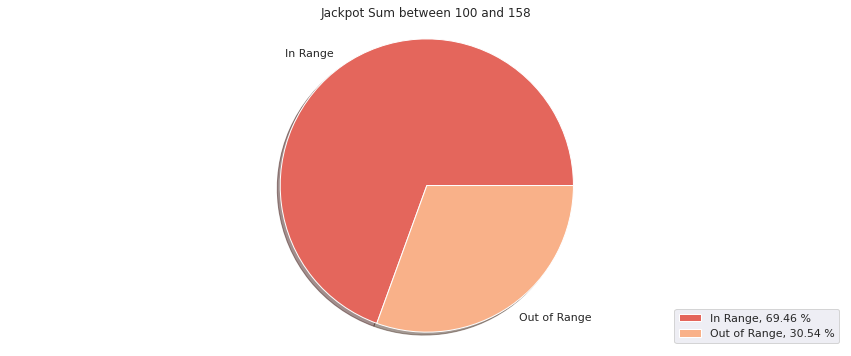

In [18]:
# Get number of even and odd numbers in a given list
def isNumbersInRange(numbers):
    sumOfNumbers = 0 
    for number in numbers:
        sumOfNumbers += number
    if (sumOfNumbers >= sumOfMeans - 29 and sumOfNumbers <= sumOfMeans + 29):
        return "In Range"
    else:
        return "Out of Range"    


def visualizeInRangeCombination():
    in_range = {}
    numbers = []
    for index, draw in lottery.iterrows():
            numbers.append(int(draw['Ball 1']))
            numbers.append(int(draw['Ball 2']))
            numbers.append(int(draw['Ball 3']))
            numbers.append(int(draw['Ball 4']))
            numbers.append(int(draw['Ball 5']))
            numbers.append(int(draw['Ball 6']))
            in_range[isNumbersInRange(numbers)] = in_range.get(isNumbersInRange(numbers), 0) + 1 
            numbers = []
    in_range_ser = pd.Series(in_range)
    print(in_range_ser)
    # Pie chart, where the slices will be ordered and plotted counter-clockwise:
    labels = in_range.keys()
    sizes = list(in_range.values())
    sizes = [x / float(len(lottery)) * 100 for x in sizes]
    fig1, ax1 = plt.subplots(figsize=(15, 6))
    colors = ["#E4665C", "#F9B189"]
    ax1.pie(sizes, labels=labels, shadow=True, colors=colors)
    plt.title("Jackpot Sum between " + str(sumOfMeans - 29) + " and " + str(int(sumOfMeans + 29)))
    plt.legend( loc = 'lower right', labels=['%s, %1.2f %%' % (l, s) for l, s in zip(labels, sizes)])
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    

visualizeInRangeCombination()

## Analysis

The results here can be quite deceiving.  
Around 70% of probability is substantial. So in simple words, if you choose to take 6 number whose sum will be between 100 and 158. That does not mean that you'll hit the jackpot 70% of the times. What that means is that 70% out of the jackpot is made out of 6 numbers whose sum falls between 100 and 158.  
Does that increases your chances, if you choose to use it?  
**Definitely!**

# If we group the three methods together, will we have a higher probability?


More specifically, if we choose the best combination of each of the latter methods, would we maximize our chances to win?  
In this case taking:
* 3 Even 3 Odd
* 3 High 3 Low
* Sum of the ball numbers is between 100 and 158


**For naming convention we'll define numbers that comform with the conditions as Elite Number**

#### Well, let's not talk about it.  See below!

Other Numbers    1621
Elite Numbers     180
dtype: int64


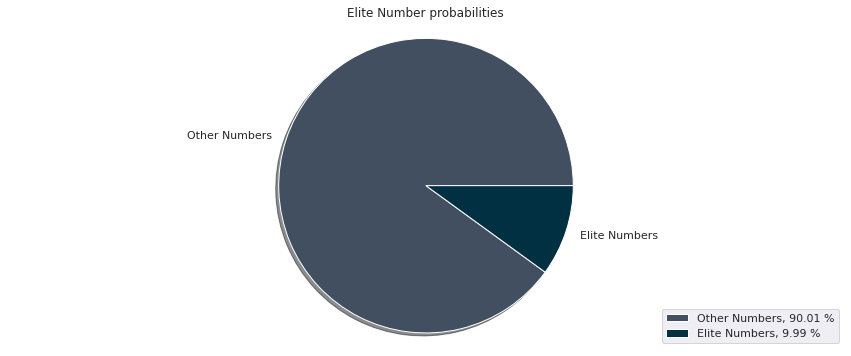

In [19]:
# We'll assume that "isEliteNumbers(numbers)" function will determine that the numbers comform with the conditions specified above.

# I know, I can optimize my code!
def isEliteNumbers(numbers):
    for number in numbers:
        if (isNumbersInRange(numbers) == "In Range" and getNumberOfEvenAndOdd(numbers) == "3 Even, 3 Odd" and getNumberOfHighAndLow(numbers) == "3 High, 3 Low"):
            return "Elite Numbers"
        else:
            return "Other Numbers"    

    
def visualizeEliteCombination():
    numbers_type = {}
    numbers = []
    for index, draw in lottery.iterrows():
            numbers.append(int(draw['Ball 1']))
            numbers.append(int(draw['Ball 2']))
            numbers.append(int(draw['Ball 3']))
            numbers.append(int(draw['Ball 4']))
            numbers.append(int(draw['Ball 5']))
            numbers.append(int(draw['Ball 6']))
            numbers_type[isEliteNumbers(numbers)] = numbers_type.get(isEliteNumbers(numbers), 0) + 1 
            numbers = []
    numbers_type_ser = pd.Series(numbers_type)
    print(numbers_type_ser)
    # Pie chart, where the slices will be ordered and plotted counter-clockwise:
    labels = numbers_type.keys()
    sizes = list(numbers_type.values())
    sizes = [x / float(len(lottery)) * 100 for x in sizes]
    fig1, ax1 = plt.subplots(figsize=(15, 6))
    colors = ["#424F60", "#003041"]
    ax1.pie(sizes, labels=labels, shadow=True, colors=colors)
    plt.title("Elite Number probabilities")
    plt.legend( loc = 'lower right', labels=['%s, %1.2f %%' % (l, s) for l, s in zip(labels, sizes)])
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    

visualizeEliteCombination()

# DO NOT PICK ALL THREE METHODS TOGETHER!

If you've taken a probability course, you should have seen it coming.
Cascading probabilities for dependent events will only worsen the result.
Simple proof:
> A: Getting 3 Even 3 Odd  
B: Getting 3 High 3 Low  
C: Getting 6 numbers whith the sum between 100 and 158
  
> P(A ∩ B ∩ C) = P(A) x P(B|A) x P(C|A ∩ B) ==> The more events you take into consideration the lesser your probabilty
  
I wont calculate the exact probability I'll keep it to you nerds out there (It's 10% duh!)

# Enough Statistics, Let's talk **MACHINE LEARNING**

So we know that this is a regression problem, so there are a lot of ways to forecast using a multivariate system.  
Model types which can be used in this context are:
* Linear Regression
* Vanilla RNN
* GRU (close similarity with the LSTM)
* CNN (Yes, google it)
* CNN + LSTM
* ConvLSTM
* Even U-net can be used here , add LSTM(s) before your dense et voila.
* Some statistical methods also include ARIMA and TBats (you can google both)

Several architectures can be used such as Encoder - Decoder, AutoEncoders, Transformers etc..

There are a lot of models, would love to see them coming into life.  

In this kernel i'll use mainly 2 types:
* LSTM
* CNN + LSTM

## LSTM (Long short term memory)

### What is LSTM?

I will assume that you already know how neural networks work.
LSTM is a recurrent NN which was mainly designed to solve the vanishing/exploding gradient problem while backpropagating.
Its architecure differs from a regular RNN. Instead of having a simple perceptron at the root, we'll have an LSTM cell.

### LSTM cell

Briefly, think of an LSTM cell as its own neural network.
It mainly contains four gates:
* Input: Gets the input
* Output: releases the output of the cell
* Forget: In a broad manner, chooses what to forget and what to remember. It has a sigmoid activation function, so it learns how much to remember/forget.
* Modulation: Adds non linearity to the input of the cell. Mainly used for faster learning convergence.

### Why LSTM?

Before explaining why LSTM, I will define the goals that I'm trying to reach and explain accordingly.  
*I first chose what I wanted to do, then decided what model to use*  
  
  
1. Since lottery sequences are dependent events, are we able to find somekind of pattern that will explain the sequence?
2. Do different lottery draws affect the result of the upcoming draw? (Will keep this one for another kernel)

Having set up our main concerns, we know that RNNs are well performing in temporal (time based) data applications.  
Well, you have your answer.  
  
      
        
        
### For more information on LSTM, visit the [publication][1].
[1]: https://www.bioinf.jku.at/publications/older/2604.pdf

## Step 1

Gather relevant data

In [20]:
lottery_ml = copy.deepcopy(lottery)
del lottery_ml['Draw Number']
del lottery_ml['Jackpot']
del lottery_ml['Date']
lottery_ml.head()

,Ball 1,Ball 2,Ball 3,Ball 4,Ball 5,Ball 6,Extra Ball
0,7,25,11,8,20,32,30
1,5,19,13,42,21,28,35
2,4,10,18,35,36,38,21
3,8,16,17,23,29,32,7
4,4,7,10,16,27,41,12


## Step 2

Normalize data for faster computations and also since we know that distributions are normal.

In [21]:
# Normalizing and downscaling the data such that mean per column is 0
scaler = StandardScaler().fit(lottery_ml.values)
transformed_dataset = scaler.transform(lottery_ml.values)
lottery_ml_normalized = pd.DataFrame(data=transformed_dataset, index=lottery_ml.index)
lottery_ml_normalized

,0,1,2,3,4,5,6
0,0.166019,1.993730,-1.071501,-2.375214,-1.626330,-0.955841,0.754941
1,-0.249547,1.034460,-0.774613,2.587724,-1.471175,-1.759046,1.172318
2,-0.457330,-0.404445,-0.032392,1.565943,0.856154,0.248967,0.003662
3,0.373801,0.554825,-0.180836,-0.185683,-0.229933,-0.955841,-1.164995
4,-0.457330,-0.884080,-1.219945,-1.207464,-0.540243,0.851371,-0.747618
...,...,...,...,...,...,...,...
1796,-0.457330,1.354217,1.006716,0.690130,0.235533,0.248967,-0.998044
1797,1.204932,1.354217,1.006716,0.398192,0.080377,0.048166,1.172318
1798,-0.872895,-1.203837,-1.516833,-1.207464,-1.316020,-1.558245,1.005367
1799,-0.872895,-0.564324,-0.626169,1.711911,1.011309,0.851371,1.756647


# Step 3

From our 1800 rows, we'll divide simple training and validation sets.  
Training/Validation= 80/20  
We'll also base our training on 50 previous games for our next prediction.  
The number of features we'll be passing = number of balls to be drawn within a game (7)  
Finally, we'll prepare both our train and label arrays to train our network on. 

In [22]:
rows_to_retain_for_test = 350
number_of_rows= lottery_ml.values.shape[0] - rows_to_retain_for_test
games_window_size = 50 #amount of past games we need to take in consideration for training (It's also the number of draws)
number_of_features = lottery_ml.values.shape[1] #balls count

In [23]:
#Number of rows = number of games to train (samples)
#Number of columns = Number of previous games (timestep)
#Number of depths = Number of features (in this case on 7 balls) (features)
train = np.empty([number_of_rows-games_window_size, games_window_size, number_of_features], dtype=float)
label = np.empty([number_of_rows-games_window_size, number_of_features], dtype=float)


# train represents the training data
# label represents the expected result

#train[2][0][5] holds the value of ball 6 (or feature number 6) in previous game 0 (that means the current game) which is actually game number 1.
#train[200][4][3] holds the value of ball 4 (or feature number 4) in previous game 4 (that means 4 games before the current draw) where the current draw is 199.

#Think about it as a row based visualization

#For each row ==> Technically we can say that every row is a training batch

for i in range(0, number_of_rows-games_window_size):
    train[i]=lottery_ml_normalized.iloc[i:i+games_window_size, 0: number_of_features]
    # the label will have the result of the next draw.
    label[i]=lottery_ml_normalized.iloc[i+games_window_size: i+games_window_size + 1, 0: number_of_features]

# Model architecture

So the model which we used was a very simple model with 2 cascading LSTM networks, each with 200 units and dropout of 0.2.

In [24]:
model = Sequential()
model.add(LSTM(200,      
            input_shape=(games_window_size, number_of_features),
            return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(200,           
               return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(number_of_features))
model.compile(loss='mse', optimizer='rmsprop', metrics=["accuracy"])

# train model normally
history =  model.fit(train, label, epochs= 500, validation_split=0.25, batch_size = 128, verbose=0)

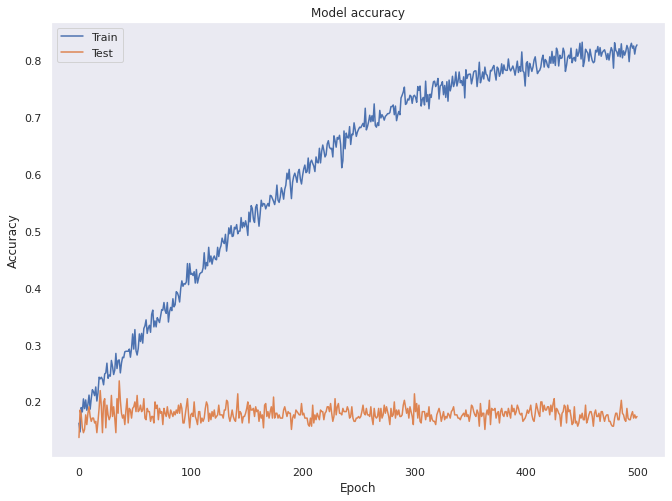

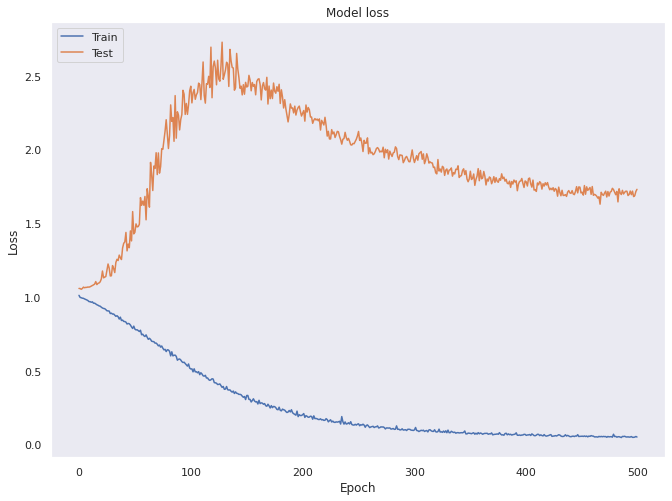

In [25]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Overfit
The model is obviously over-fit and was not able to train on the data.

# Step 5

The best way to evaluate the accuracy in my opinion is through a plot.
Here, the X axis represents the draw number, while the Y axis repesents the ball number.
I will show plots for Ball 1, 4 and the extra ball so that it doesn't get messy.  

In [26]:
validation_df_0 = pd.DataFrame(columns = ['Validation Draw','Ball','Value'])
validation_df_0["Validation Draw"] = pd.to_numeric(validation_df_0["Validation Draw"])
validation_df_0["Value"] = pd.to_numeric(validation_df_0["Value"])

validation_df_1 = pd.DataFrame(columns = ['Validation Draw','Ball','Value'])
validation_df_1["Validation Draw"] = pd.to_numeric(validation_df_1["Validation Draw"])
validation_df_1["Value"] = pd.to_numeric(validation_df_1["Value"])

validation_df_3 = pd.DataFrame(columns = ['Validation Draw','Ball','Value'])
validation_df_3["Validation Draw"] = pd.to_numeric(validation_df_3["Validation Draw"])
validation_df_3["Value"] = pd.to_numeric(validation_df_3["Value"])

validation_df_6 = pd.DataFrame(columns = ['Validation Draw','Ball','Value'])
validation_df_6["Validation Draw"] = pd.to_numeric(validation_df_6["Validation Draw"])
validation_df_6["Value"] = pd.to_numeric(validation_df_6["Value"])

In [27]:
for i in range(lottery_ml.values.shape[0]-rows_to_retain_for_test, lottery_ml.values.shape[0] - games_window_size ):
    to_predict = lottery_ml.iloc[i:i+games_window_size].values.tolist()
    scaled_to_predict = scaler.transform(to_predict)
    scaled_predicted_output_1 = model.predict(np.array([scaled_to_predict]))
    predicted_draw = scaler.inverse_transform(scaled_predicted_output_1).astype(int)[0]
    actual_draw = lottery_ml.iloc[i+games_window_size].values.tolist()
    validation_df_0 = validation_df_0.append({'Validation Draw': int(i), 'Ball': "Actual", 'Value': actual_draw[0]}, ignore_index=True)
    validation_df_0 = validation_df_0.append({'Validation Draw': int(i), 'Ball': "Predicted", 'Value': predicted_draw[0] }, ignore_index=True)
    validation_df_1 = validation_df_1.append({'Validation Draw': int(i), 'Ball': "Actual", 'Value': actual_draw[1]}, ignore_index=True)
    validation_df_1 = validation_df_1.append({'Validation Draw': int(i), 'Ball': "Predicted", 'Value': predicted_draw[1] }, ignore_index=True)
    validation_df_3 = validation_df_3.append({'Validation Draw': int(i), 'Ball': "Actual", 'Value': actual_draw[3]}, ignore_index=True)
    validation_df_3 = validation_df_3.append({'Validation Draw': int(i), 'Ball': "Predicted", 'Value': predicted_draw[3] }, ignore_index=True)
    validation_df_6 = validation_df_6.append({'Validation Draw': int(i), 'Ball': "Actual", 'Value': actual_draw[6]}, ignore_index=True)
    validation_df_6 = validation_df_6.append({'Validation Draw': int(i), 'Ball': "Predicted", 'Value': predicted_draw[6] }, ignore_index=True)

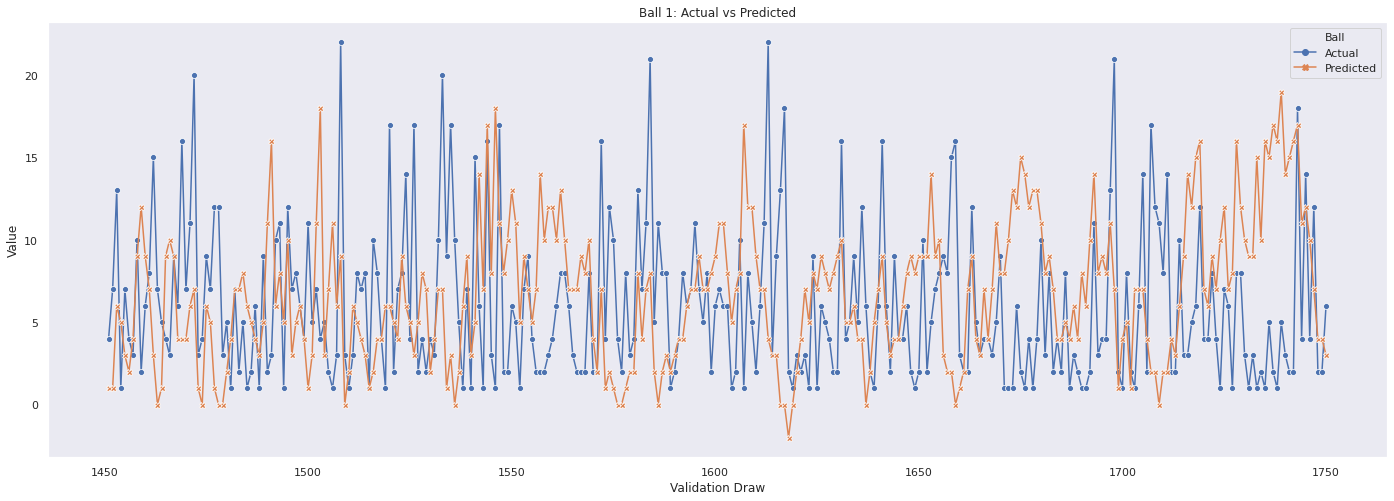

In [28]:
fig, ax = plt.subplots(figsize=(24, 8))
plt.title("Ball 1: Actual vs Predicted")
ax = sns.lineplot(x="Validation Draw", y="Value", hue="Ball",style="Ball",data=validation_df_0,markers=True, dashes=False)

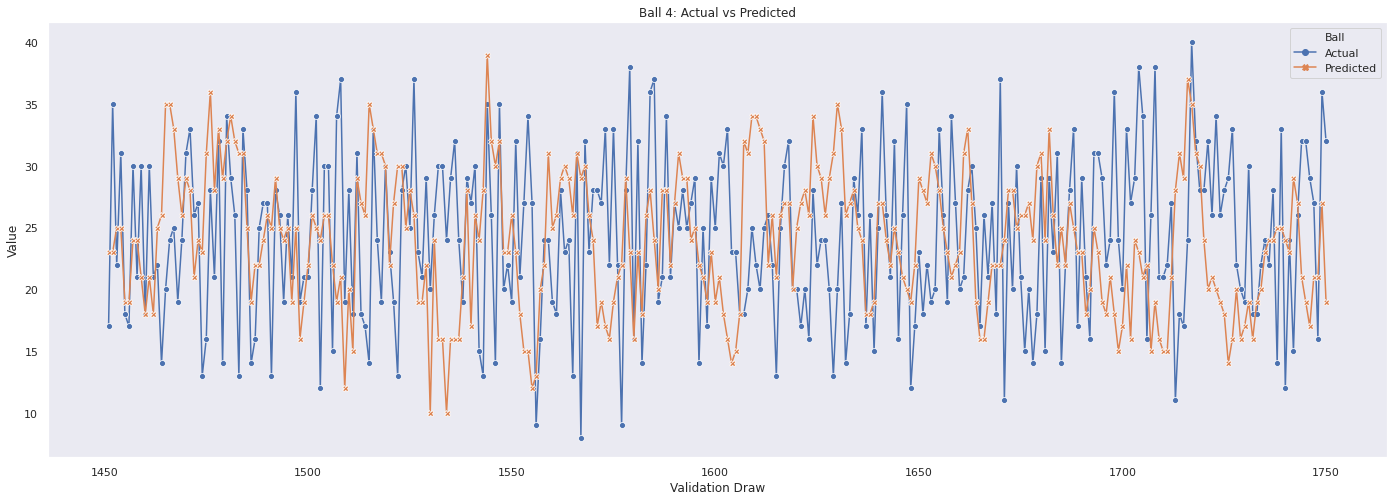

In [29]:
fig, ax = plt.subplots(figsize=(24, 8))
plt.title("Ball 4: Actual vs Predicted")
ax = sns.lineplot(x="Validation Draw", y="Value", hue="Ball",style="Ball",data=validation_df_3,markers=True, dashes=False)

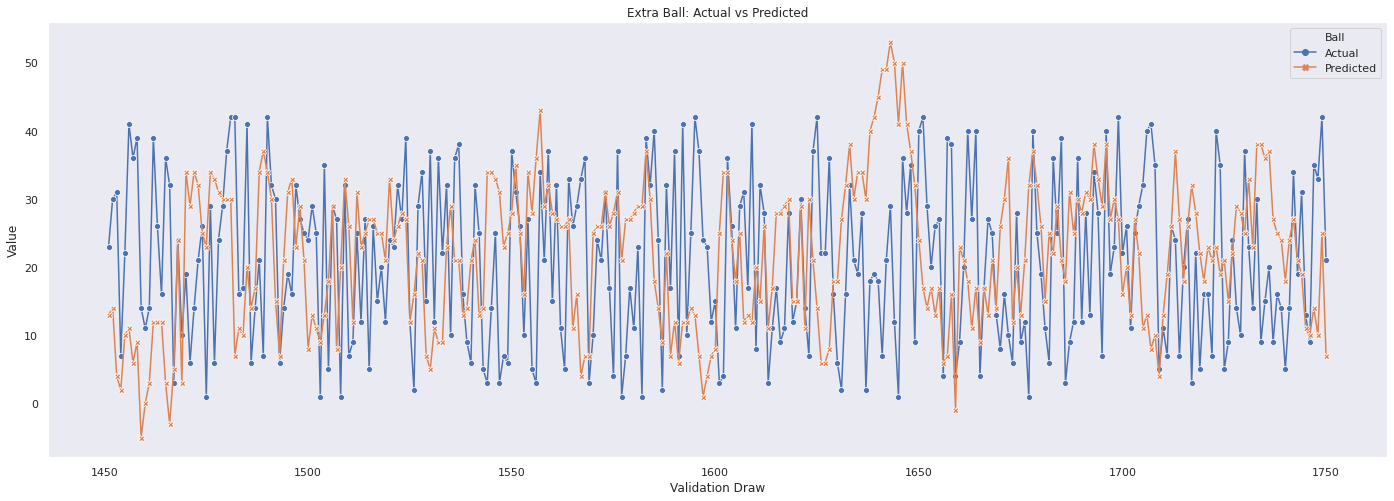

In [30]:
fig, ax = plt.subplots(figsize=(24, 8))
plt.title("Extra Ball: Actual vs Predicted")
ax = sns.lineplot(x="Validation Draw", y="Value", hue="Ball",style="Ball",data=validation_df_6,markers=True, dashes=False)

# Training Visualization
We'll also take a look at the training, to visualize the overfitting.

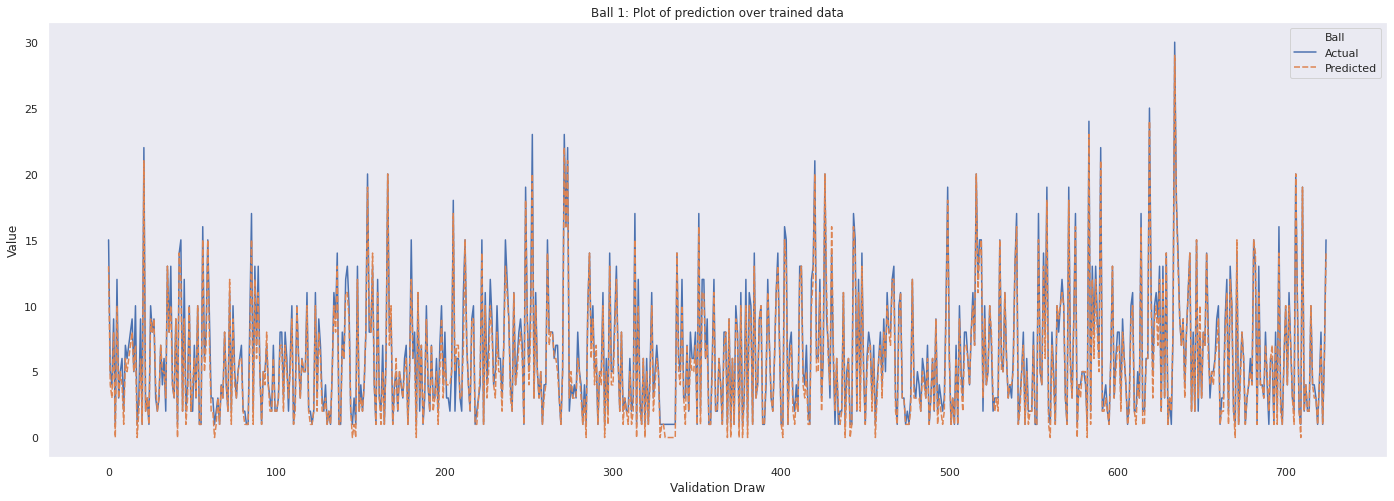

In [31]:

trained_df = pd.DataFrame(columns = ['Validation Draw','Ball','Value'])
trained_df["Validation Draw"] = pd.to_numeric(validation_df_0["Validation Draw"])
trained_df["Value"] = pd.to_numeric(trained_df["Value"])

for i in range(0, int((lottery_ml.values.shape[0]-rows_to_retain_for_test)/2)):
    to_predict = lottery_ml.iloc[i:i+games_window_size].values.tolist()
    scaled_to_predict = scaler.transform(to_predict)
    scaled_predicted_output_1 = model.predict(np.array([scaled_to_predict]))
    predicted_draw = scaler.inverse_transform(scaled_predicted_output_1).astype(int)[0]
    actual_draw = lottery_ml.iloc[i+games_window_size].values.tolist()
    trained_df = trained_df.append({'Validation Draw': int(i), 'Ball': "Actual", 'Value': actual_draw[0]}, ignore_index=True)
    trained_df = trained_df.append({'Validation Draw': int(i), 'Ball': "Predicted", 'Value': predicted_draw[0] }, ignore_index=True)
    
fig, ax = plt.subplots(figsize=(24, 8))
plt.title("Ball 1: Plot of prediction over trained data")
ax = sns.lineplot(x="Validation Draw", y="Value", hue="Ball",style="Ball",data=trained_df,markers=False, dashes=True)

# Analysis on Method 1

So we already see that model is overfit. However, one can make the statement that the trend can have some similarities on different draws.
In all cases, that's not really conclusive and there is not particular pattern.

## Next step
So, in order to solve the latter we might need to infer new features. To do that, we will use a CNN + LSTM architecture.  
More technically, we're shifting our domain from only temporal to spatio - temporal.  
We're not relying anymore on time based draws only. Instead, we're trying to infer some spatial features about the data that might affect the next batch of balls being drawn.  


# Method 2

This method makes use of a CNN + LSTM architecture.

In [32]:
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import ConvLSTM2D, Conv1D, MaxPooling1D
from keras.layers.normalization import BatchNormalization

## Preparing the dataset

So phase 1 is to prepare the dataset.  
The inputs of the model have to be reshaped.  
The train and test datasets are divided similarly to the previous method. 

In [33]:
def prepare_datasets(lottery_ml_normalized):
    train = np.empty([number_of_rows,games_window_size,number_of_features], dtype=int)
    label = np.empty([number_of_rows,number_of_features], dtype=int)
    test = np.empty([rows_to_retain_for_test,games_window_size,number_of_features], dtype=int)
    
    for i in range(0, number_of_rows):
        train[i]=lottery_ml_normalized.iloc[i:i+games_window_size, 0: number_of_features]
        label[i]=lottery_ml_normalized.iloc[i+games_window_size: i+games_window_size + 1, 0: number_of_features]

    for i in range(number_of_rows, number_of_rows + rows_to_retain_for_test - games_window_size):
        test[i-number_of_rows]=lottery_ml_normalized.iloc[i:i+games_window_size, 0: number_of_features]

    # current shape is [samples, timesteps, features]
    # reshape into [samples, subsequences, timesteps, features]

    # subsequences means the number of rows every single data represents.
    
    # In our case it is 1 subsequence,then the whole draw as treated as a single a row (that means the 6 balls)
    train = train.reshape([number_of_rows, 1, games_window_size, number_of_features])
    test = test.reshape([rows_to_retain_for_test, 1, games_window_size, number_of_features])
    
    return train, label, test

# Building & Training the model

In [34]:
def build_model(train, label, n_epochs, val_ratio):
    
    model = Sequential()
    # input (batch, steps, channels)
    model.add(TimeDistributed(Conv1D(filters=3, kernel_size=16, activation='relu'), input_shape=(None, games_window_size, number_of_features)))
    model.add(TimeDistributed(Conv1D(filters=3, kernel_size=32, activation='relu')))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(512, activation='relu',return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(512, activation='relu'))
    model.add(Dropout(0.3))
    #model.add(Flatten())
    #model.add(LSTM(10, activation='relu'))
    model.add(Dense(7))

    model.compile(optimizer='adam', loss='mse', metrics=["accuracy"])

    history = model.fit(train, label,validation_split=val_ratio, epochs=n_epochs, verbose=0)
    
    return history

In [35]:
train, label, test = prepare_datasets(lottery_ml_normalized)
history = build_model(train, label, 2000, 0.3)

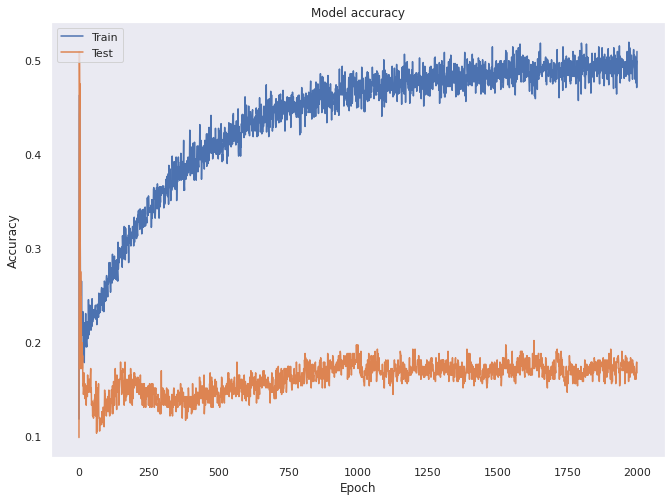

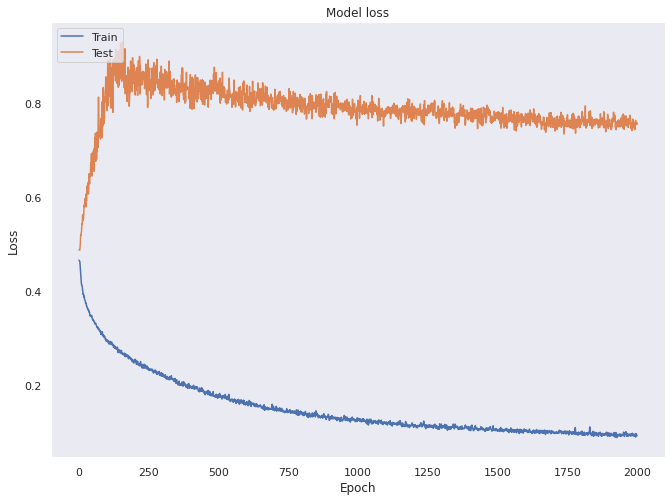

In [36]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Model Overfit

The model is also overfit, no real significant changes to our predictions.
It seems that even spatial data have no correlation with the resulting draw.

# Testing on new data

In [37]:
# As for the testing, we'll plot a confusion matrix
test_pred = pd.DataFrame(columns = ["Predicted", "Actual", "Occurences"])

test_pred["Predicted"] = pd.to_numeric(test_pred["Predicted"])
test_pred["Actual"] = pd.to_numeric(test_pred["Actual"])
test_pred["Occurences"] = pd.to_numeric(test_pred["Occurences"])


occurences = {}
#for test_in in test:
for i in range(0,test.shape[0]):
        prediction_normalized = model.predict(test[i], verbose = 0)
        pred = scaler.inverse_transform(prediction_normalized).astype(int)[0]
        actual = lottery_ml.iloc[i+rows_to_retain_for_test]
        for nb in range(0, 7):
            occurences[str(pred[nb]) + "" + str(actual[nb])]  = occurences.get(str(pred[nb]) + "" + str(actual[nb]), 0) + 1 
            if(occurences[str(pred[nb]) + "" + str(actual[nb])] == 1):
                test_pred = test_pred.append({'Predicted': pred[nb], 'Actual': actual[nb], 'Occurences': occurences[str(pred[nb]) + "" + str(actual[nb])] }, ignore_index=True)
            else:
                test_pred.loc[(test_pred["Predicted"] == pred[nb]) & (test_pred["Actual"] == actual[nb]), "Occurences"] = occurences.get(str(pred[nb]) + "" + str(actual[nb]), 0) + 1
                #print(ok)
        #print(pred)
        #print(actual)
        #break
print(test_pred)


      Predicted  Actual  Occurences
0             2       5           3
1             7      10           6
2            21      15           6
3            26      21           9
4            37      26           4
...         ...     ...         ...
1096          0      15           1
1097          1      20           1
1098         13      36           1
1099          9      21           1
1100         13      24           1

[1101 rows x 3 columns]


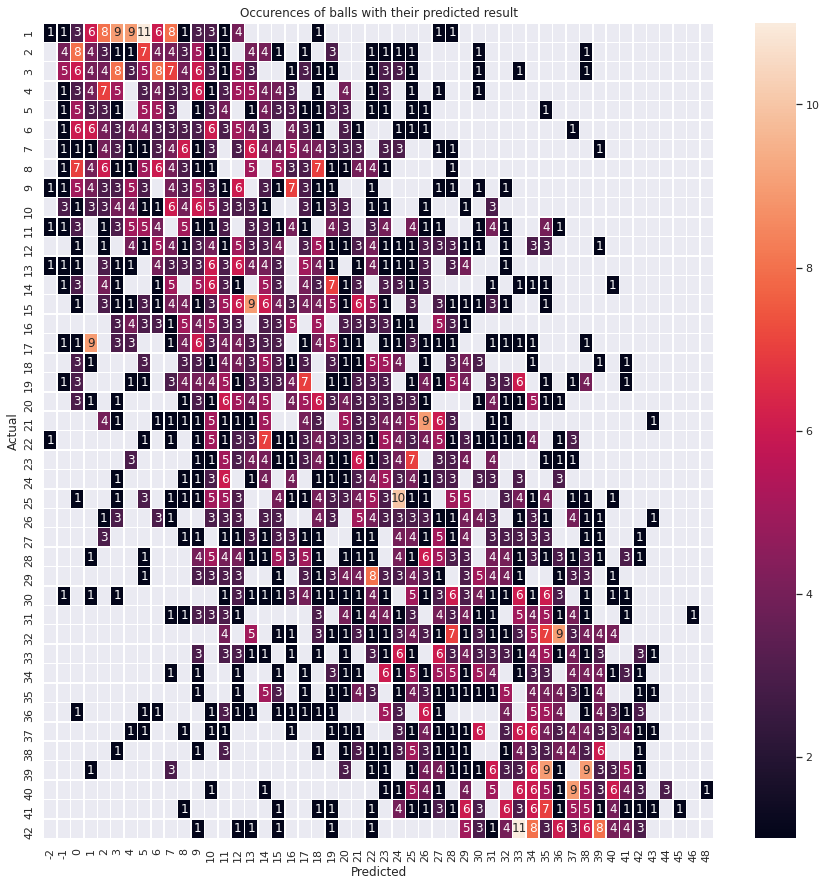

In [38]:
test_pred_hm = test_pred.pivot("Actual", "Predicted", "Occurences")
f, ax = plt.subplots(figsize=(15, 15))
plt.title("Occurences of balls with their predicted result")
sns.heatmap(test_pred_hm, annot=True,linewidths=0.5, ax=ax)

## Analysis

First thing you can see that the plot is pretty scattered.  
In simple terms, for each actual ball drawn of the heat map, we count the number of occurences of what the model predicted for it.  
Theoretically if the model was accurate Ball #32 should only match with ball #32  
However, through the testing dataset, 32 was matched once with -13 (which does not exist), once with -1, 3 times with 11, 3 times with 32, etc..  
That means that our model performs really poorly also on the testing dataset

# Final Method that we'll try (Most Promising)

Let's take in consideration the results that we have found throughout our statistics.  
With all the models that we have worked on so far, none of the inputs that we used took in consideration extra features.  In other terms, our input for the learning agent was only the ball sequence.  
In this method, we'll try to mix up some stuff.  

## Trial 1
Since we know that the probability of picking a sequence from the winning draw where the sum of the balls is between 100 - 158 is 70%, then we'll try to integrate this feature in to our model in the hope of increasing the chances of picking a right sequence.

## Trial 2
We'll evaluate the feature of having 3 odds and 3 evens in our predictions.


**N.B:** We will not take other features into consideration for the reason provided in the section of **DO NOT PICK ALL THREE METHODS TOGETHER!**  
  
  
For the sake of simplicity I'll use the same model architecture as the previous method 

## Preparing the dataset

The most important part here is to add the new feature into consideration.  

### Adding the missing feature
Our input data looks like this:  
Ball 1 --> Extra Ball.
The dilemna in this case is that we are not able to add an extra feature quantitavely because it doesn't make sense.  
For instance, adding a column which holds the SUM of the numbers would typically do nothing since we're training our model to have a prediction of the next draw.  
So knowing that, two consecutive draws might have different or same sums, leading the network to learn nothing.  

Instead, and for the sake of simplicity we will **only train on the data we want to predict**. (Yes, there exists a better combination of what I am showing)  
That means that our training set will be only formed by the predictions we want it to make.  
In a way, we're only feeding our neural network with the pattern we want it to learn

## Trial 1

We will be only training on draws where the sum of the first 6 numbers is between 100 - 158

In [39]:
lottery_ml_sum = copy.deepcopy(lottery_ml)
lottery_ml_sum['SUM'] = 0
lottery_ml_sum

,Ball 1,Ball 2,Ball 3,Ball 4,Ball 5,Ball 6,Extra Ball,SUM
0,7,25,11,8,20,32,30,0
1,5,19,13,42,21,28,35,0
2,4,10,18,35,36,38,21,0
3,8,16,17,23,29,32,7,0
4,4,7,10,16,27,41,12,0
...,...,...,...,...,...,...,...,...
1796,4,21,25,29,32,38,9,0
1797,12,21,25,27,31,37,35,0
1798,2,5,8,16,22,29,33,0
1799,2,9,14,36,37,41,42,0


### Filter the training set 
Keep only the rows we want

In [40]:
def sumBalls(balls):
    sumCurrent = 0
    for ball in balls:
        sumCurrent += ball
    return sumCurrent

indexsToDrop = []
currentBalls = []
for index, draw in lottery_ml_sum.iterrows():
    currentBalls.append(draw['Ball 1'])
    currentBalls.append(draw['Ball 2'])
    currentBalls.append(draw['Ball 3'])
    currentBalls.append(draw['Ball 4'])
    currentBalls.append(draw['Ball 5'])
    currentBalls.append(draw['Ball 6'])
    sumCurrentBalls = sumBalls(currentBalls)
    if( sumCurrentBalls >= 100 and  sumCurrentBalls <= 158):
        draw['SUM'] = 100
    else:
        draw['SUM'] = 30
        indexsToDrop.append(index)  
    currentBalls = []

lottery_ml_sum = lottery_ml_sum.drop(indexsToDrop)

del lottery_ml_sum['SUM']
lottery_ml_sum

,Ball 1,Ball 2,Ball 3,Ball 4,Ball 5,Ball 6,Extra Ball
0,7,25,11,8,20,32,30
1,5,19,13,42,21,28,35
2,4,10,18,35,36,38,21
3,8,16,17,23,29,32,7
4,4,7,10,16,27,41,12
...,...,...,...,...,...,...,...
1793,18,20,23,26,27,41,19
1794,4,15,27,32,33,41,31
1796,4,21,25,29,32,38,9
1797,12,21,25,27,31,37,35


# Train the model

In [41]:
rows_to_retain_for_test = 350
number_of_rows= lottery_ml_sum.values.shape[0] - rows_to_retain_for_test
games_window_size = 50 #amount of past games we need to take in consideration for training (It's also the number of draws)
number_of_features = lottery_ml_sum.values.shape[1] #balls count

In [42]:
# Normalizing and downscaling the data such that mean per column is 0
scaler = StandardScaler().fit(lottery_ml_sum.values)
transformed_dataset = scaler.transform(lottery_ml_sum.values)
lottery_ml_normalized = pd.DataFrame(data=transformed_dataset, index=lottery_ml_sum.index)
number_of_features = lottery_ml_sum.values.shape[1] #balls count
lottery_ml_normalized

,0,1,2,3,4,5,6
0,0.318670,2.730329,-1.421291,-3.287265,-2.335541,-1.284100,0.774202
1,-0.196057,1.466213,-1.019203,3.415541,-2.129143,-2.247465,1.189700
2,-0.453421,-0.429961,-0.013981,2.035551,0.966817,0.160946,0.026305
3,0.576033,0.834155,-0.215026,-0.330145,-0.477964,-1.284100,-1.137090
4,-0.453421,-1.062019,-1.622336,-1.710134,-0.890759,0.883469,-0.721592
...,...,...,...,...,...,...,...
1793,3.149669,1.676899,0.991240,0.261279,-0.890759,0.883469,-0.139894
1794,-0.453421,0.623469,1.795417,1.444127,0.347625,0.883469,0.857301
1796,-0.453421,1.887585,1.393328,0.852703,0.141228,0.160946,-0.970891
1797,1.605488,1.887585,1.393328,0.458421,-0.065169,-0.079895,1.189700


In [43]:
train, label, test = prepare_datasets(lottery_ml_normalized)
history = build_model(train, label, 500, 0.3)

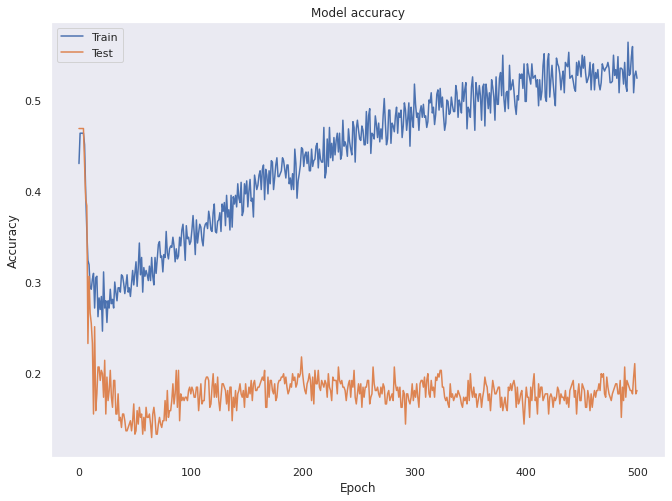

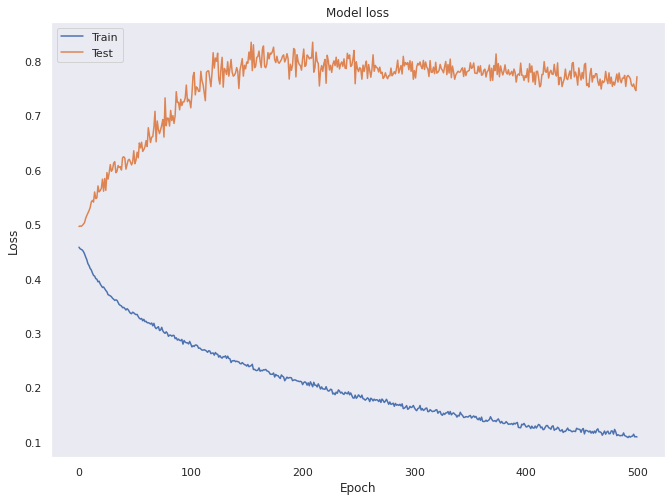

In [44]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Analysis

The results didn't really improve on the previous findings, that means that the trained combination wasn't able to crack the lottery. **BUT** it was representative of a big portion of how the output could look like (I will elaborate on this more in the analysis of the following trial)

## Trial 2

We will be only training on draws where we have 3 even balls and 3 odd balls out of the first 6 balls.  
Same steps as Trial 1 with minor tweeks.

In [45]:
lottery_ml_even = copy.deepcopy(lottery_ml)
lottery_ml_even['EVEN'] = 0
lottery_ml_even

,Ball 1,Ball 2,Ball 3,Ball 4,Ball 5,Ball 6,Extra Ball,EVEN
0,7,25,11,8,20,32,30,0
1,5,19,13,42,21,28,35,0
2,4,10,18,35,36,38,21,0
3,8,16,17,23,29,32,7,0
4,4,7,10,16,27,41,12,0
...,...,...,...,...,...,...,...,...
1796,4,21,25,29,32,38,9,0
1797,12,21,25,27,31,37,35,0
1798,2,5,8,16,22,29,33,0
1799,2,9,14,36,37,41,42,0


In [46]:
def evenBalls(balls):
    numEven = 0
    for ball in balls:
        if(ball % 2 == 0):
            numEven += 1
    return numEven

indexsToDrop = []
currentBalls = []
for index, draw in lottery_ml_even.iterrows():
    currentBalls.append(draw['Ball 1'])
    currentBalls.append(draw['Ball 2'])
    currentBalls.append(draw['Ball 3'])
    currentBalls.append(draw['Ball 4'])
    currentBalls.append(draw['Ball 5'])
    currentBalls.append(draw['Ball 6'])
    numEven = evenBalls(currentBalls)
    if( numEven == 3):
        draw['EVEN'] = numEven
    else:
        draw['EVEN'] = numEven
        indexsToDrop.append(index)  
    currentBalls = []

lottery_ml_even = lottery_ml_even.drop(indexsToDrop)

del lottery_ml_even['EVEN']
lottery_ml_even

,Ball 1,Ball 2,Ball 3,Ball 4,Ball 5,Ball 6,Extra Ball
0,7,25,11,8,20,32,30
3,8,16,17,23,29,32,7
4,4,7,10,16,27,41,12
7,8,14,19,22,31,37,33
13,3,4,17,27,34,40,38
...,...,...,...,...,...,...,...
1786,5,8,19,22,36,39,20
1788,1,10,11,14,21,34,16
1793,18,20,23,26,27,41,19
1796,4,21,25,29,32,38,9


In [47]:
rows_to_retain_for_test = 350
number_of_rows= lottery_ml_even.values.shape[0] - rows_to_retain_for_test
games_window_size = 50 #amount of past games we need to take in consideration for training (It's also the number of draws)
number_of_features = lottery_ml_even.values.shape[1] #balls count

In [48]:
# Normalizing and downscaling the data such that mean per column is 0
scaler = StandardScaler().fit(lottery_ml_even.values)
transformed_dataset = scaler.transform(lottery_ml_even.values)
lottery_ml_normalized = pd.DataFrame(data=transformed_dataset, index=lottery_ml_even.index)
number_of_features = lottery_ml_even.values.shape[1] #balls count
lottery_ml_normalized

,0,1,2,3,4,5,6
0,0.264597,2.105751,-1.078887,-2.353568,-1.601585,-1.023039,0.742868
3,0.481220,0.630720,-0.163263,-0.180417,-0.223095,-1.023039,-1.177749
4,-0.385271,-0.844310,-1.231491,-1.194554,-0.529426,0.924606,-0.760223
7,0.481220,0.302935,0.141945,-0.325294,0.083236,0.058986,0.993383
13,-0.601894,-1.335987,-0.163263,0.399090,0.542733,0.708201,1.410909
...,...,...,...,...,...,...,...
1786,-0.168648,-0.680418,0.141945,-0.325294,0.849064,0.491796,-0.092183
1788,-1.035140,-0.352634,-1.078887,-1.484308,-1.448419,-0.590229,-0.426203
1793,2.647448,1.286289,0.752361,0.254213,-0.529426,0.924606,-0.175688
1796,-0.385271,1.450181,1.057569,0.688843,0.236402,0.275391,-1.010739


In [49]:
train, label, test = prepare_datasets(lottery_ml_normalized)
history = build_model(train, label, 500, 0.3)

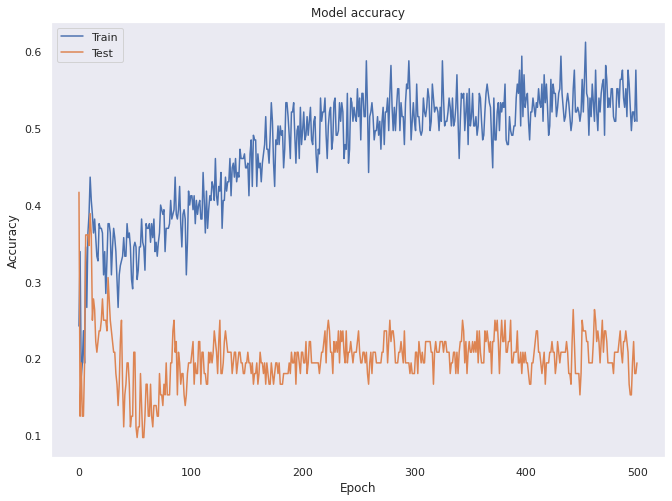

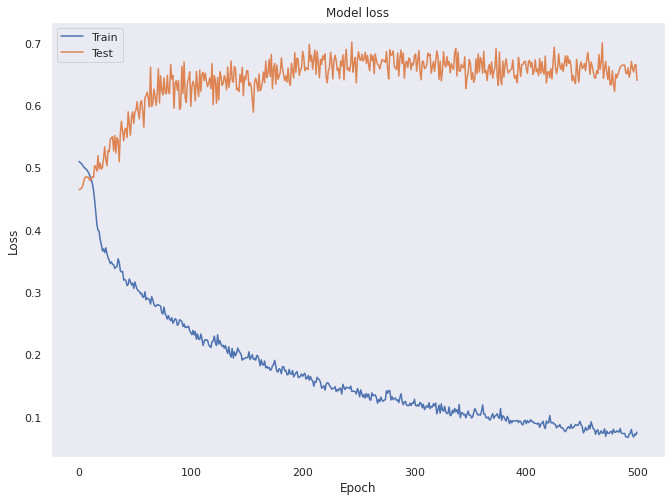

In [50]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Analysis

In this case, the results worsened a lot.  
A lot of hypothesis could be introduced here, but we can for sure elaborate that this combination is not the optimal one to always base our assumptions on.
That means that following the previous trial, it is better to follow the latter combination rather to follow this one.
In the same taste, you would also predict that using HIGH - LOW combination would lead to the same result, but I will keep this one for you to implement.

# Closing Comments

I wont take long, this post was already filled with conclusive information.  
Definitely the lottery is not rigged (at least that's what this data shows).  
I hope I have provided you with good insights about Lotteries, time series (at least an intro) and machine learning in general.  
Personally, I don't play the lotto and I plan on keeping it that way.
> *That's all folks!*